# Imports

In [12]:
%matplotlib notebook

import importlib
import time
import numpy as np
import pandas as pd
import functools
import torch
import numpy as np
import gpytorch
import re
import time
import warnings
import math
import botorch 

from torch import Tensor

from matplotlib import pyplot as plt

from scipy import stats

from gpytorch.kernels.kernel import Kernel
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.test_functions.synthetic import SyntheticTestFunction

from botorch.models import FixedNoiseGP, ModelListGP
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP


from ax.models.torch import alebo as alebo_implementation_ax
from ax.models.random.alebo_initializer import ALEBOInitializer
from ax.modelbridge.strategies.alebo import ALEBOStrategy

from ax.models.torch_base import TorchModel


from typing import Any, Callable, Dict, List, MutableMapping, Optional, Tuple, Union

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# System Information

In [13]:
print(botorch.__version__)
print(gpytorch.__version__)
print(torch.__version__)

0.3.3
1.3.1
1.7.1


# Problem
I am trying to re-implement ALEBO in BOTorch, to easily implement features such as heteroscedastic GPs and sparse GPs.   
I test my re-implementation against the Branin_100 function.   
The AX version of ALEBO can achieve very good results on this function, as shown here:  
https://github.com/facebookresearch/alebo/blob/master/quickstart.ipynb  
I am trying to achieve similar performance (in speed, memory usage and minima location) with a BOTorch re-implementation.   

I define the following helper functions below:
1. Branin_100 function creation (inheriting from botorch.test_functions.synthetic.SyntheticTestFunction).   
2. Branin_100_ALEBO_BOTorch wrapper (analogous to obj() here: https://botorch.org/tutorials/bo_with_warped_gp)   
3. gen_projection (taken from ax.modelbridge.strategies.alebo https://github.com/facebook/Ax/blob/master/ax/modelbridge/strategies/alebo.py)
4. generate_initial_data_Branin_100 (analogous to generate_initial_data() in above tutorial)   
5. standardise_outputs (normalises outputs to have zero mean and standard deviation one).  
6. initialize_model (analogous to initialize_model() in above tutorial)  
7. update_random_observations_Branin_100 (analogous to update_random_observations() in above tutorial)  

I then provide my BO loop in full, below. 

Note: I often name variables according to their dimensions, and if they're an array or tensor.   
I had to change between dimensions and arrays/tensors often in the implementation, so I hope you can excuse this.   
example_variable_D_x_n_array for instance, would be a variable of dimensions (D x N), and a numpy array.   
D = original dimensionality, d = embedding dimensionality, and n = number of sample points. 

# Helper functions:

## Branin_100 function creation 
I can see that the Branin function is already implemented in botorch.test_functions.synthetic.SyntheticTestFunction. I make some simple edits to it, to create a Branin_100 function, which only has two dimensions of interest:

In [14]:
class Branin_100_Shaheen(SyntheticTestFunction):

    dim = 100 # Edited dim to be 100 
    _bounds = [(-5.0, 10.0), (0.0, 15.0)]*50 # Edited bounds for 100-dim function
    _optimal_value = 0.397887
    _optimizers = [(-math.pi, 12.275), (math.pi, 2.275), (9.42478, 2.475)]

    def evaluate_true(self, X: Tensor) -> Tensor:
        t1 = (
            X[..., 1]
            - 5.1 / (4 * math.pi ** 2) * X[..., 0] ** 2
            + 5 / math.pi * X[..., 0]
            - 6
        )
        t2 = 10 * (1 - 1 / (8 * math.pi)) * torch.cos(X[..., 0])
        return t1 ** 2 + t2 + 10

## Branin_100_ALEBO_BOTorch wrapper
I wrap the Branin_100 function above, so I can input a set of sample points, train_x:


In [15]:
def Branin_100_ALEBO_BOTorch_wrapper(train_x):
    branin_100_ = Branin_100_Shaheen(noise_std = 0.0, negate = False)
    number_of_sample_points = train_x.shape[1]
    fitness_values = np.zeros(shape=(number_of_sample_points))
    
    for i in range(0, number_of_sample_points):
        param_set = train_x[:,i].T
        # Convert param set to tensor, for input to evaluate_true on test function
        param_set = torch.tensor(param_set)
        fitness_values[i] = branin_100_.evaluate_true(X = param_set)

    return fitness_values

## gen_projection 
Lifted straight from ax.modelbridge.strategies.alebo, minus self parameter, as it was part of the ALEBOStrategy class.

In [16]:
def gen_projection(d: int, D: int, dtype: torch.dtype, device: torch.device) -> torch.Tensor:
    """Generate the projection matrix B as a (d x D) tensor"""
    B0 = torch.randn(d, D, dtype=dtype, device=device)
    B = B0 / torch.sqrt((B0 ** 2).sum(dim=0))
    return B

## standardise_outputs
I couldn't see any normalisation of the outputs, to aid the GP fitting, but I could be completely wrong here.   
I implemented a rudimentary normalisation, taking the mean to zero and the standard deviation to one:

In [17]:
def standardise_outputs(outputs_vector):
    mean_of_outputs = np.mean(outputs_vector)
    std_dev_of_outputs = np.std(outputs_vector)
    
    outputs_vector -= mean_of_outputs
    outputs_vector /= std_dev_of_outputs
    
    return outputs_vector, mean_of_outputs, std_dev_of_outputs

## generate_initial_data_Branin_100
In this function, I take a requested number of sample points, the projection matrix B, and output:
1. The training sample points
2. The normalised training objective values
3. The best objective
4. The training sample points, projected down to the embedding dimension 
5. The mean of the training objectives 
6. The standard deviation of the training objectives 

I use the ALEBOInitializer to generate these training sample points, which I think is used correctly, but I could be wrong. 

In [18]:
def generate_initial_data_Branin_100(n, B: torch.Tensor):
    # D = original dimensionality
    # n = number of sample points
    # d = embedding dimensionality
    
    # Initialize ALEBOInitializer
    ALEBO_Initializer = ALEBOInitializer(B.cpu().numpy()) 
    
    # Use ALEBOInitializer to generate initial sample points
    train_x_n_x_D_array , __ = ALEBO_Initializer.gen(n = n, bounds=[(-1.0, 1.0)] * B.shape[1]) 
    
    # Create train_x_n_x_D as a tensor, for torch.matmul with B
    train_x_n_x_D_tensor = torch.from_numpy(train_x_n_x_D_array)

    # Pass training data to Branin_100 wrapper, get objective values
    exact_obj = Branin_100_ALEBO_BOTorch_wrapper(train_x_n_x_D_array.T)
    exact_obj_n_x_1 = torch.tensor(exact_obj).unsqueeze(-1)
    
    # Normalise objective values 
    exact_obj_normalised, mean_of_initial_data, std_dev_of_initial_data = standardise_outputs(exact_obj)
    train_obj_normalised = torch.tensor(exact_obj_normalised).unsqueeze(-1)  # add output dimension
    
    # Get best objective value, unnormalised
    best_observed_value = exact_obj_n_x_1.min().item()
    
    # Project training data down to embedding dim 
    train_x_projected_down_d_x_n_tensor = torch.matmul(B, train_x_n_x_D_tensor.T)

    # output training inputs, normalised training objectives, best objective, 
    #training inputs projected down, mean of training objectives, std. dev of training objectives
    return train_x_n_x_D_tensor, train_obj_normalised, best_observed_value, train_x_projected_down_d_x_n_tensor, mean_of_initial_data, std_dev_of_initial_data

## initialize_model 
Here, I needed to re-implement the initialize_model functions in the BOTorch tutorials.   
Digging around the ALEBO code, I found the ALEBOGP class, which I instantiate with some parameters which again, I think should be correct. 

In [19]:
def initialize_model(train_x_projected_down, train_obj, B, noise):
    '''
    Args from ALEBOGP:
    B: (d x D) Projection matrix.
    train_X: (n x d) X training data.
    train_Y: (n x 1) Y training data.
    train_Yvar: (n x 1) Noise variances of each training Y.
    '''
    dtype = torch.double
    device = torch.device('cpu')
    train_yvar = torch.tensor(noise**2, device=device, dtype=dtype)
    model = alebo_implementation_ax.ALEBOGP(train_X = train_x_projected_down, 
                                            train_Y = train_obj, 
                                            train_Yvar = train_yvar.expand_as(train_obj), 
                                            B = B).to(train_x_projected_down) 
    
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

## update_random_observations_Branin_100
Here, I needed to replicate the random selection and execution of a sample point, as in the BOTorch tutorials, and used ALEBOInitializer to do so. 

In [20]:
def update_random_observations_Branin_100(best_random):
    """Simulates a quasi-random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    ALEBO_Initializer = ALEBOInitializer(B.cpu().numpy())
    rand_x_1_x_D , __ = ALEBO_Initializer.gen(n = 1, bounds=[(-1.0, 1.0)] * B.shape[1]) 
    rand_x_D_x_1 = rand_x_1_x_D.T
    next_random_objective_value = torch.tensor(Branin_100_ALEBO_BOTorch_wrapper(rand_x_D_x_1)).unsqueeze(-1).min().item()
    best_random.append(min(best_random[-1], next_random_objective_value))       
    return best_random

# BO Loop 

In [21]:
N_TRIALS = 3
N_BATCH = 15
n_init = 5
torch.manual_seed(1)

# I had to increase this from 0.1 to avoid numerical instabilities, but I think it may be affecting performance somewhat 
noise = 1.0

device = torch.device('cpu')
dtype = torch.double

# Initialise results lists for N_TRIALS
best_observed_all, best_random_all = [], []

# Create projection matrix B
B = gen_projection(d = 2, D = 100, dtype = torch.double, device = 'cpu')

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    
    # Initialise results list for N_BATCH
    best_observed, best_random = [], []
    
    # Call helper function to generate initial training data
    train_x, train_obj_normalised, best_observed_value, train_x_projected_down_d_x_n, mean_init_data, std_dev_init_data = generate_initial_data_Branin_100(n= n_init, B = B)

    # Transpose training sample points projected down, for input to initialize_model
    train_x_projected_down_n_x_d_tensor = train_x_projected_down_d_x_n.T 
    mll, model = initialize_model(train_x_projected_down_n_x_d_tensor, train_obj_normalised, B, noise = noise)

    # Append best value from training data to results lists
    best_observed.append(best_observed_value)
    best_random.append(best_observed_value)
    init_state_dict = model.state_dict()

    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):    
                
        # Fit ALEBO GP model
        train_yvar = torch.tensor(noise**2, device = device, dtype = dtype)
        m_b = alebo_implementation_ax.get_fitted_model(B = B, 
                               train_X = train_x_projected_down_n_x_d_tensor, 
                               train_Y = train_obj_normalised,
                               train_Yvar = train_yvar.expand_as(train_obj_normalised),
                               restarts = 20,
                               nsamp = 512,
                               init_state_dict = init_state_dict)
        
        # Get MLL for model 
        mll_fitted = ExactMarginalLogLikelihood(m_b.likelihood, m_b)
        
        # We use the NEI as our acquisition function. 
        Nei = qNoisyExpectedImprovement(model=m_b, X_baseline=train_x_projected_down_n_x_d_tensor)
        
        # Optimize acquisition function and get new observation
        # Note, we use the alebo_acqf_optimizer, as defined in the ALEBO AX implementation
        new_x_1_x_d_tensor, new_obj_tensor = alebo_implementation_ax.alebo_acqf_optimizer(Nei, 
                                                    bounds = [None, None],
                                                    n = 1,
                                                    raw_samples = 512,
                                                    num_restarts = 20,
                                                    B = B,
                                                    inequality_constraints = None,
                                                    fixed_features = None,
                                                    rounding_func = None
                                                    )
        
        
        # Create pseudoinverse of B
        pinv_B_D_x_d_array = np.linalg.pinv(B)

        # Project new sample point, from embedding space to original space, via pseudoinverse of B
        new_x_projected_up_D_x_1_array = pinv_B_D_x_d_array @ new_x_1_x_d_tensor.numpy().T

        # Update training points in embedding space, with new point 
        train_x_projected_down_n_x_d_tensor = torch.cat([train_x_projected_down_n_x_d_tensor, new_x_1_x_d_tensor])
        
        # Project training data from embedding space, to original space, via pseudoinverse of B 
        train_x_projected_down_then_up_D_x_n_array = pinv_B_D_x_d_array @ train_x_projected_down_n_x_d_tensor.numpy().T
        new_obj_projected_up = torch.tensor(Branin_100_ALEBO_BOTorch_wrapper(new_x_projected_up_D_x_1_array)).unsqueeze(-1)

        # Normalise new objective value
        new_obj_projected_up_normalised = (new_obj_projected_up - mean_init_data) / std_dev_init_data
        
        # Append the new (normalised) objective value to the other (normalised) objective values
        train_obj_normalised = torch.cat([train_obj_normalised, torch.tensor(new_obj_projected_up_normalised)])

        # Execute random sample point, append best value to best_random list
        best_random = update_random_observations_Branin_100(best_random)
                
        # Get the best value amongst all the normalised objective values
        best_value = train_obj_normalised.min().item()
        
        # Append the best value, amongst all normalised objectives, to the best_observed array
        best_observed.append(best_value)
        
        # Retrain the GP model on the training sample points (plus new value), and training objectives (plus new value)
        mll, model = initialize_model(train_x_projected_down_n_x_d_tensor, train_obj_normalised, B = B, noise = noise)
        init_state_dict = model.state_dict()

        print (f'reached end of BO loop, iteration = {iteration}')

    best_observed_all.append(best_observed)
    best_random_all.append(best_random)
best_observed_all = (np.asarray(best_observed_all) * std_dev_init_data) + mean_init_data
best_random_all = (np.asarray(best_random_all) * std_dev_init_data) + mean_init_data


Trial  1 of 3 

[INFO 02-17 10:00:57] ax.models.torch.alebo: Generated sequential candidate 1 of 1
<ipython-input-21-f0a076a98d7b>:88: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



reached end of BO loop, iteration = 1


[INFO 02-17 10:01:04] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 2


[INFO 02-17 10:01:12] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 3


[INFO 02-17 10:01:24] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 4


[INFO 02-17 10:01:44] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 5


[INFO 02-17 10:02:07] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 6


[INFO 02-17 10:02:18] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 7


[INFO 02-17 10:02:28] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 8


[INFO 02-17 10:02:37] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 9


[INFO 02-17 10:02:48] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 10


[INFO 02-17 10:03:01] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 11


[INFO 02-17 10:03:28] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 12


[INFO 02-17 10:03:41] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 13


[INFO 02-17 10:03:56] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 14


[INFO 02-17 10:04:15] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 15

Trial  2 of 3 

[INFO 02-17 10:04:22] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 1


[INFO 02-17 10:04:28] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 2


[INFO 02-17 10:04:35] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 3


[INFO 02-17 10:04:41] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 4


[INFO 02-17 10:04:48] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 5


[INFO 02-17 10:04:55] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 6


[INFO 02-17 10:05:06] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 7


[INFO 02-17 10:05:19] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 8


[INFO 02-17 10:05:35] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 9


[INFO 02-17 10:05:53] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 10


[INFO 02-17 10:06:11] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 11


[INFO 02-17 10:06:26] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 12


[INFO 02-17 10:06:42] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 13


[INFO 02-17 10:06:56] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 14


[INFO 02-17 10:07:11] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 15

Trial  3 of 3 

[INFO 02-17 10:07:17] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 1


[INFO 02-17 10:07:24] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 2


[INFO 02-17 10:07:32] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 3


[INFO 02-17 10:07:42] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 4


[INFO 02-17 10:07:56] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 5


[INFO 02-17 10:08:06] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 6


[INFO 02-17 10:08:30] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 7


[INFO 02-17 10:08:41] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 8


[INFO 02-17 10:08:52] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 9


[INFO 02-17 10:09:01] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 10


[INFO 02-17 10:09:13] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 11


[INFO 02-17 10:09:25] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 12


[INFO 02-17 10:09:39] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 13


[INFO 02-17 10:09:53] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 14


[INFO 02-17 10:10:07] ax.models.torch.alebo: Generated sequential candidate 1 of 1


reached end of BO loop, iteration = 15


# Visualise results

best_observed_all = [[312.18479811  41.33407431  41.33407431  41.33407431  41.33407431
   41.33407431  41.33407431  41.33407431  41.33407431  41.33407431
   41.33407431  41.33407431  41.33407431  41.33407431  41.33407431
   41.33407431]
 [302.09637519  45.35745784  45.35745784  45.35745784  45.35745784
   45.35745784  45.35745784  45.35745784  45.35745784  45.35745784
   45.35745784  45.35745784  45.35745784  45.35745784  45.35745784
   45.35745784]
 [313.57888834  44.9337661   44.9337661   44.9337661   44.9337661
   44.9337661   44.9337661   44.9337661   44.9337661   44.9337661
   44.9337661   44.9337661   44.9337661   44.9337661   44.9337661
   44.9337661 ]]
best_random_all = [[312.18479811 312.18479811 312.18479811 312.18479811 312.18479811
  312.18479811 312.18479811 312.18479811 312.18479811 312.18479811
  312.18479811 312.18479811 312.18479811 312.18479811 312.18479811
  312.18479811]
 [302.09637519 302.09637519 302.09637519 302.09637519 302.09637519
  302.09637519 302.09637519 3

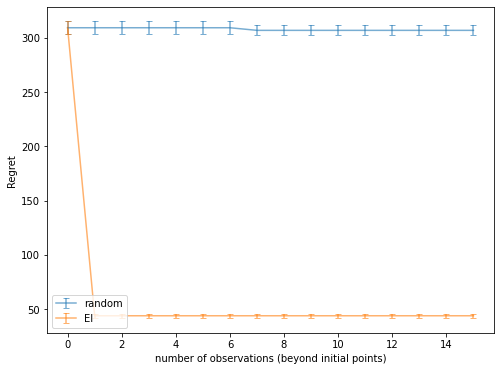

In [23]:
%matplotlib inline

def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

print (f'best_observed_all = {best_observed_all}')
print (f'best_random_all = {best_random_all}')

iters = np.arange(N_BATCH + 1)
y = np.asarray(best_observed_all)
y_rnd =  np.asarray(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5, capsize=3, alpha=0.6)
ax.errorbar(iters, y.mean(axis=0), yerr=ci(y), label="EI", linewidth=1.5, capsize=3, alpha=0.6)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='Regret')
ax.legend(loc="lower left")